# Coursework: Age regression from brain MRI

Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement different supervised learning approaches for age regression from brain MRI. We provided data from a total of 652 healthy subjects, that is split into different development sets and a held-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented all approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings.

#### Read the text descriptions and the provided code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.

### Running on Colab or Azure

In [22]:
! pip install SimpleITK==1.2.2 
# ! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
# ! unzip brainage-data.zip

# data directory
data_dir = 'data/brain_age/'

### Running on DoC lab machines

In [23]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [24]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

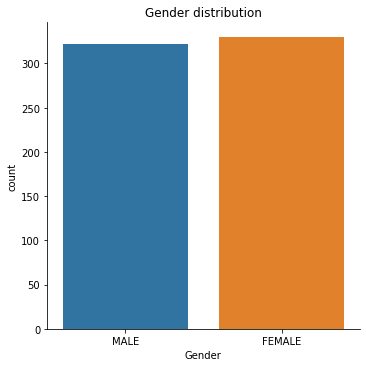

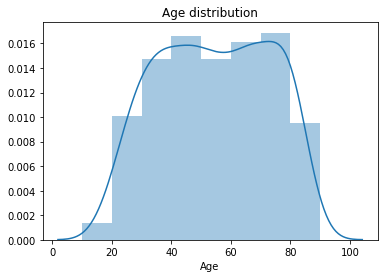

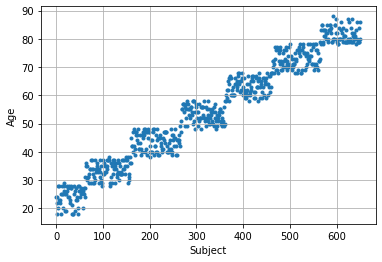

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [26]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


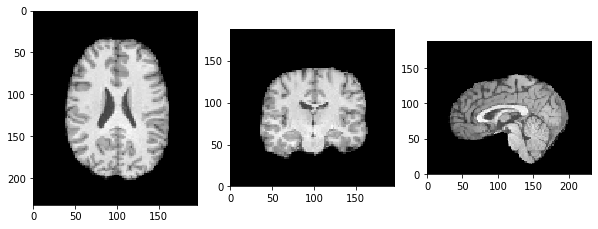

Brain mask (used in part A)


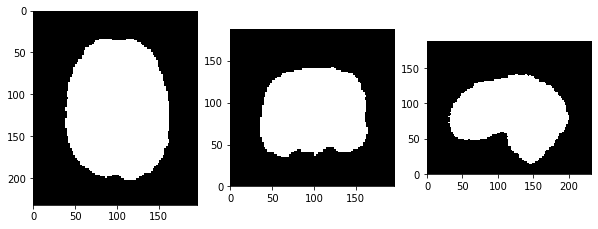

Spatially normalised grey matter maps (used in part B and C)


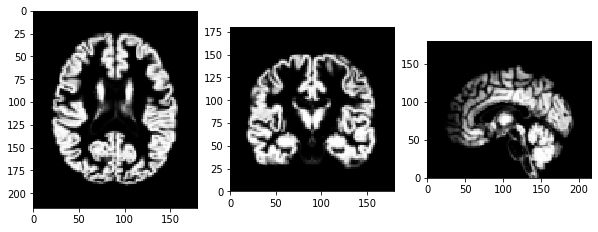

In [27]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

# Grey matter map
gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
gm = sitk.ReadImage(gm_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B and C)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B and C only. If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is on your VM. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal.

#### Imports

In [28]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [29]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [30]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla V100-SXM2-16GB


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [31]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 100
learning_rate = 0.001
batch_size = 4
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [32]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [33]:
# LOAD ACTUAL TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
# dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


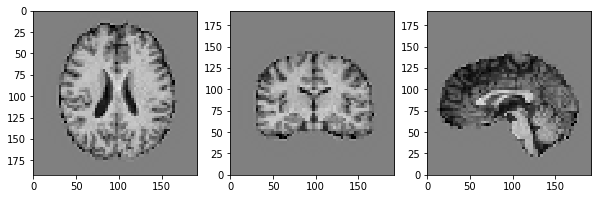

Segmentation


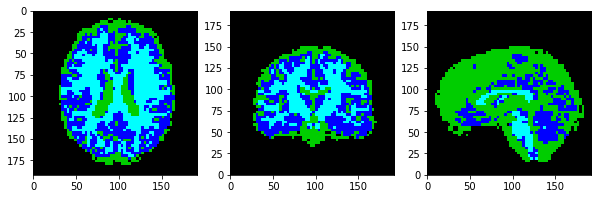

Mask


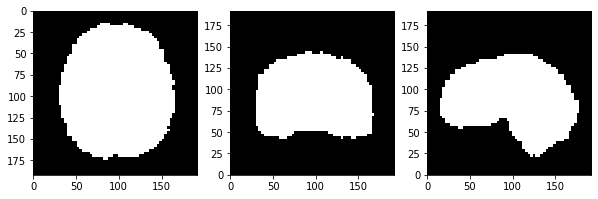

In [34]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [35]:
########################################
# BUILD A BETTER MODEL HERE

def create_convolution_block(in_channels, out_channels, activation):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm3d(out_channels),
        activation,)

def create_trans_block(in_channels, out_channels, activation):
    return nn.Sequential(
        nn.ConvTranspose3d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm3d(out_channels),
        activation,
    )

def create_convolution_2_block(in_channels, out_channels, activation):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm3d(out_channels),
        activation,
        nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm3d(out_channels),
    )

class UNet3D(nn.Module):

    def __init__(self, num_classes):
        super(UNet3D, self).__init__()
        
        activation = nn.LeakyReLU(0.2, inplace=True)
        
        # Downsample
        self.down1 = create_convolution_2_block(1, 32, activation)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.down2 = create_convolution_2_block(32, 64, activation)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        
        # Bridge
        self.bridge = create_convolution_2_block(64, 128, activation)
        
        # Upsample
        self.trans1 = create_trans_block(128, 128, activation)
        self.upsample1 = create_convolution_2_block(192, 64, activation)
        
        self.trans2 = create_trans_block(64, 64, activation)
        self.upsample2 = create_convolution_2_block(96, 32, activation)
        
        self.out = create_convolution_block(32, num_classes, activation)
        
        
    def forward(self, x):

        down_1 = self.down1(x) # [4, 32, 64, 64, 64]
        pool_1 = self.pool1(down_1) # [4, 32, 32, 32, 32]
        down_2 = self.down2(pool_1) # [4, 64, 32, 32, 32]
        pool_2 = self.pool2(down_2) # [4, 64, 16, 16, 16]
        
        bridge = self.bridge(pool_2) # [4, 128, 16, 16, 16]
        
        trans_1 = self.trans1(bridge) # [4, 128, 32, 32, 32]
        concat_1 = torch.cat([trans_1, down_2], dim=1) # [4, 192, 32, 32, 32]
        up_1 = self.upsample1(concat_1) # [4, 64, 32, 32, 32]
        
        trans_2 = self.trans2(up_1) # [4, 64, 64, 64, 64]
        concat_2 = torch.cat([trans_2, down_1], dim=1) # [4, 96, 64, 64, 64]
        up_2 = self.upsample2(concat_2) # 
        
        out = self.out(up_2) # 
        return out
        
        

class BetterNet3D(nn.Module):

    def __init__(self, num_classes):
        super(BetterNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm3d(num_features=16,momentum=0.2)
        self.dropout_1 = nn.Dropout(p=0.55)
        self.conv2 = nn.Conv3d(16, 64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv3d(64,128,kernel_size=3,padding=1)
        self.conv3_bn = nn.BatchNorm3d(num_features=128,momentum=0.2)
        self.dropout_2 = nn.Dropout(p=0.45)
        self.conv4 = nn.Conv3d(128, 64, kernel_size=3, padding=1)
        self.conv4_bn = nn.BatchNorm3d(num_features=64,momentum=0.2)
        self.dropout_3 = nn.Dropout(p=0.25)
        self.conv5 = nn.Conv3d(64,16,kernel_size=3,padding=1)
        self.conv6 = nn.Conv3d(16,num_classes,kernel_size=3,padding=1)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.dropout_1(x)
        x = F.relu(self.conv2(x))
        
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = self.dropout_2(x)
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = self.dropout_3(x)
        x = F.relu(self.conv5(x))
        x = self.conv6(x)
        return F.softmax(x, dim=1)
    
########################################

class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(8, 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return F.softmax(x, dim=1)

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.964053
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.946360


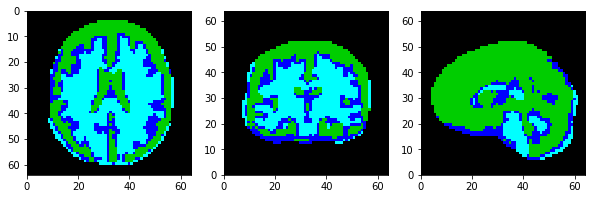

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.916762
+ TRAINING 	Epoch: 3 	Loss: 0.891362
+ TRAINING 	Epoch: 4 	Loss: 0.867238
+ TRAINING 	Epoch: 5 	Loss: 0.857114
+ TRAINING 	Epoch: 6 	Loss: 0.840309
+ TRAINING 	Epoch: 7 	Loss: 0.817504
+ TRAINING 	Epoch: 8 	Loss: 0.805613
+ TRAINING 	Epoch: 9 	Loss: 0.807547
+ TRAINING 	Epoch: 10 	Loss: 0.800921
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.777783


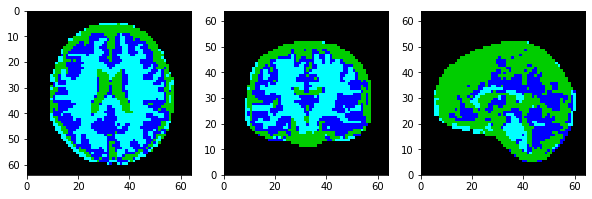

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.755176
+ TRAINING 	Epoch: 12 	Loss: 0.765838
+ TRAINING 	Epoch: 13 	Loss: 0.734441
+ TRAINING 	Epoch: 14 	Loss: 0.746591
+ TRAINING 	Epoch: 15 	Loss: 0.723332
+ TRAINING 	Epoch: 16 	Loss: 0.695493
+ TRAINING 	Epoch: 17 	Loss: 0.702217
+ TRAINING 	Epoch: 18 	Loss: 0.689979
+ TRAINING 	Epoch: 19 	Loss: 0.695405
+ TRAINING 	Epoch: 20 	Loss: 0.678269
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.674013


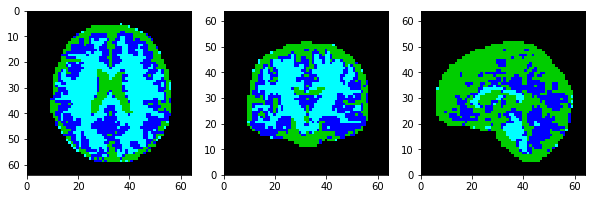

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.683105
+ TRAINING 	Epoch: 22 	Loss: 0.645024
+ TRAINING 	Epoch: 23 	Loss: 0.669001
+ TRAINING 	Epoch: 24 	Loss: 0.617741
+ TRAINING 	Epoch: 25 	Loss: 0.634858
+ TRAINING 	Epoch: 26 	Loss: 0.615160
+ TRAINING 	Epoch: 27 	Loss: 0.583794
+ TRAINING 	Epoch: 28 	Loss: 0.591754
+ TRAINING 	Epoch: 29 	Loss: 0.597133
+ TRAINING 	Epoch: 30 	Loss: 0.582127
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.590603


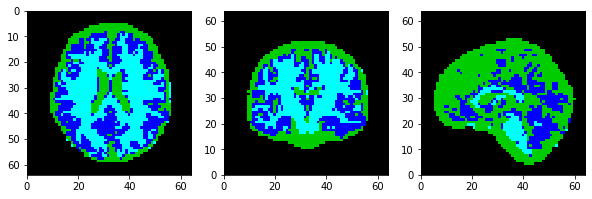

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.576979
+ TRAINING 	Epoch: 32 	Loss: 0.570541
+ TRAINING 	Epoch: 33 	Loss: 0.568833
+ TRAINING 	Epoch: 34 	Loss: 0.574154
+ TRAINING 	Epoch: 35 	Loss: 0.556682
+ TRAINING 	Epoch: 36 	Loss: 0.543282
+ TRAINING 	Epoch: 37 	Loss: 0.547262
+ TRAINING 	Epoch: 38 	Loss: 0.539708
+ TRAINING 	Epoch: 39 	Loss: 0.536433
+ TRAINING 	Epoch: 40 	Loss: 0.510216
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.529248


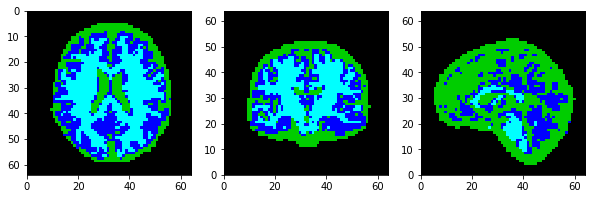

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.490489
+ TRAINING 	Epoch: 42 	Loss: 0.522235
+ TRAINING 	Epoch: 43 	Loss: 0.511776
+ TRAINING 	Epoch: 44 	Loss: 0.500932
+ TRAINING 	Epoch: 45 	Loss: 0.479949
+ TRAINING 	Epoch: 46 	Loss: 0.472091
+ TRAINING 	Epoch: 47 	Loss: 0.472740
+ TRAINING 	Epoch: 48 	Loss: 0.485362
+ TRAINING 	Epoch: 49 	Loss: 0.461594
+ TRAINING 	Epoch: 50 	Loss: 0.458731
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.464474


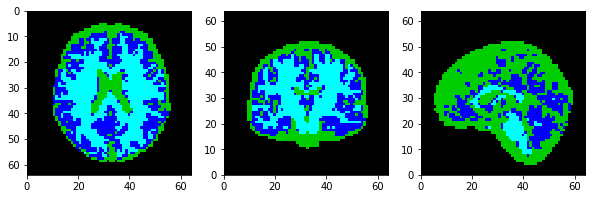

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.443808
+ TRAINING 	Epoch: 52 	Loss: 0.431128
+ TRAINING 	Epoch: 53 	Loss: 0.445112
+ TRAINING 	Epoch: 54 	Loss: 0.438115
+ TRAINING 	Epoch: 55 	Loss: 0.429777
+ TRAINING 	Epoch: 56 	Loss: 0.422055
+ TRAINING 	Epoch: 57 	Loss: 0.435661
+ TRAINING 	Epoch: 58 	Loss: 0.420712
+ TRAINING 	Epoch: 59 	Loss: 0.416142
+ TRAINING 	Epoch: 60 	Loss: 0.411000
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.418982


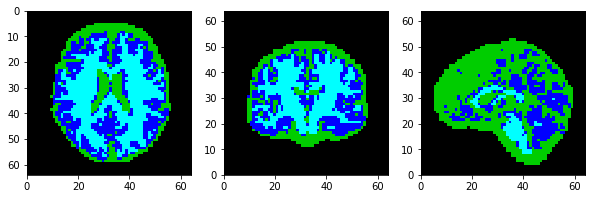

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.407612
+ TRAINING 	Epoch: 62 	Loss: 0.408752
+ TRAINING 	Epoch: 63 	Loss: 0.401443
+ TRAINING 	Epoch: 64 	Loss: 0.398567
+ TRAINING 	Epoch: 65 	Loss: 0.388844
+ TRAINING 	Epoch: 66 	Loss: 0.392311
+ TRAINING 	Epoch: 67 	Loss: 0.382381
+ TRAINING 	Epoch: 68 	Loss: 0.381826
+ TRAINING 	Epoch: 69 	Loss: 0.381956
+ TRAINING 	Epoch: 70 	Loss: 0.378558
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.376042


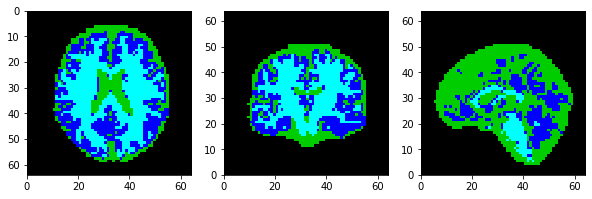

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.369294
+ TRAINING 	Epoch: 72 	Loss: 0.347788
+ TRAINING 	Epoch: 73 	Loss: 0.353011
+ TRAINING 	Epoch: 74 	Loss: 0.358290
+ TRAINING 	Epoch: 75 	Loss: 0.339093
+ TRAINING 	Epoch: 76 	Loss: 0.356672
+ TRAINING 	Epoch: 77 	Loss: 0.339703
+ TRAINING 	Epoch: 78 	Loss: 0.336877
+ TRAINING 	Epoch: 79 	Loss: 0.343532
+ TRAINING 	Epoch: 80 	Loss: 0.346374
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.337050


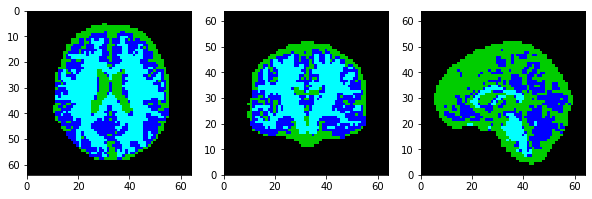

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.331304
+ TRAINING 	Epoch: 82 	Loss: 0.338541
+ TRAINING 	Epoch: 83 	Loss: 0.339240
+ TRAINING 	Epoch: 84 	Loss: 0.314877
+ TRAINING 	Epoch: 85 	Loss: 0.306842
+ TRAINING 	Epoch: 86 	Loss: 0.308044
+ TRAINING 	Epoch: 87 	Loss: 0.302087
+ TRAINING 	Epoch: 88 	Loss: 0.310650
+ TRAINING 	Epoch: 89 	Loss: 0.298155
+ TRAINING 	Epoch: 90 	Loss: 0.302229
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.306549


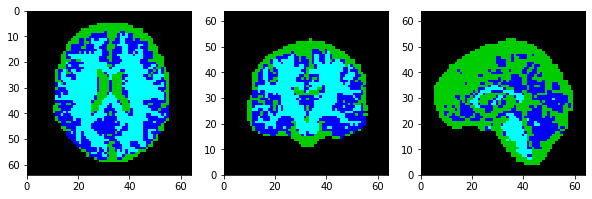

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.301333
+ TRAINING 	Epoch: 92 	Loss: 0.290732
+ TRAINING 	Epoch: 93 	Loss: 0.304273
+ TRAINING 	Epoch: 94 	Loss: 0.300082
+ TRAINING 	Epoch: 95 	Loss: 0.293960
+ TRAINING 	Epoch: 96 	Loss: 0.287220
+ TRAINING 	Epoch: 97 	Loss: 0.275979
+ TRAINING 	Epoch: 98 	Loss: 0.291560
+ TRAINING 	Epoch: 99 	Loss: 0.269104
+ TRAINING 	Epoch: 100 	Loss: 0.302474
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 0.288151


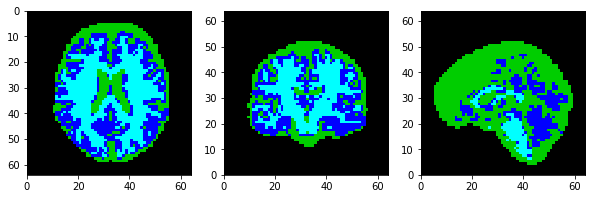

--------------------------------------------------

Finished TRAINING.


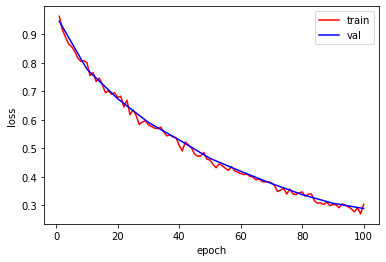

In [36]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
torch.cuda.empty_cache()
torch.manual_seed(rnd_seed) #fix random seed


model = UNet3D(num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [37]:
#Training data, 500 subjects

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

###############################################

#Test data, 100 subjects
# meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
# ids_seg_test = list(meta_data_reg_test['subject_id'])
# files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
# files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
# files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

###############################################

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:14<00:00,  6.72it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


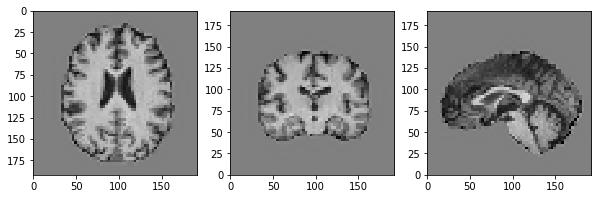

Segmentation


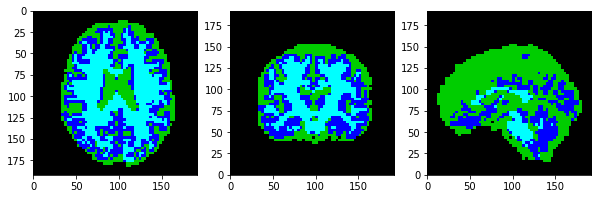

Mask


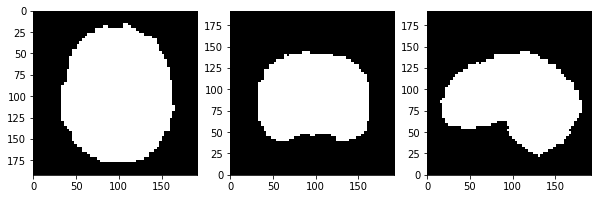

In [38]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly others) to evaluate the segmentation performance.**

START TESTING...
+ TESTING 	Loss: 0.300243


Reference segmentation


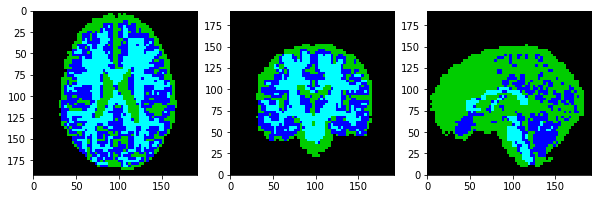

Predicted segmentation


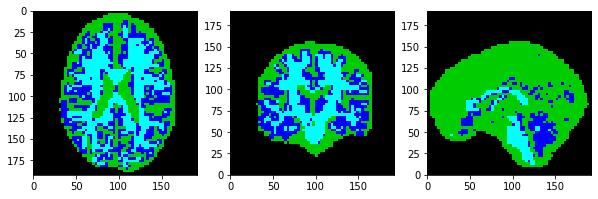


Finished TESTING.


In [39]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = UNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
dice = 0
smooth = 1.

dice_CSF = []
dice_GM = []
dice_WM = []
overlap_results = []

with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
    
        
        # Dice Similary Coefficient 
        reference = sample['seg']
        segmentation = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        segmentation.CopyInformation(sample['seg'])
        reference_arr = sitk.GetArrayFromImage(reference)
        prediction_arr = sitk.GetArrayFromImage(prediction)
        segmentation_arr = sitk.GetArrayFromImage(segmentation)
        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
        
        for idx, tissue in enumerate([dice_CSF,dice_GM,dice_WM]):
            reference_arr_tissue = (reference_arr == (idx+1)).astype(np.uint8)
            prediction_arr_tissue = (prediction_arr == (idx+1)).astype(np.uint8)
            
            tissue_reference = sitk.GetImageFromArray(reference_arr_tissue)
            tissue_prediction = sitk.GetImageFromArray(prediction_arr_tissue)
            overlap_measures_filter.Execute(tissue_reference,tissue_prediction)
            tissue.append(overlap_measures_filter.GetDiceCoefficient())            
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

In [40]:
print('Dice for class CSF: ', np.mean(dice_CSF))
print('Dice for class  GM: ', np.mean(dice_GM ))
print('Dice for class  WM: ', np.mean(dice_WM))

Dice for class CSF:  0.7932316023938847
Dice for class  GM:  0.8566878895124876
Dice for class  WM:  0.9211797705614537


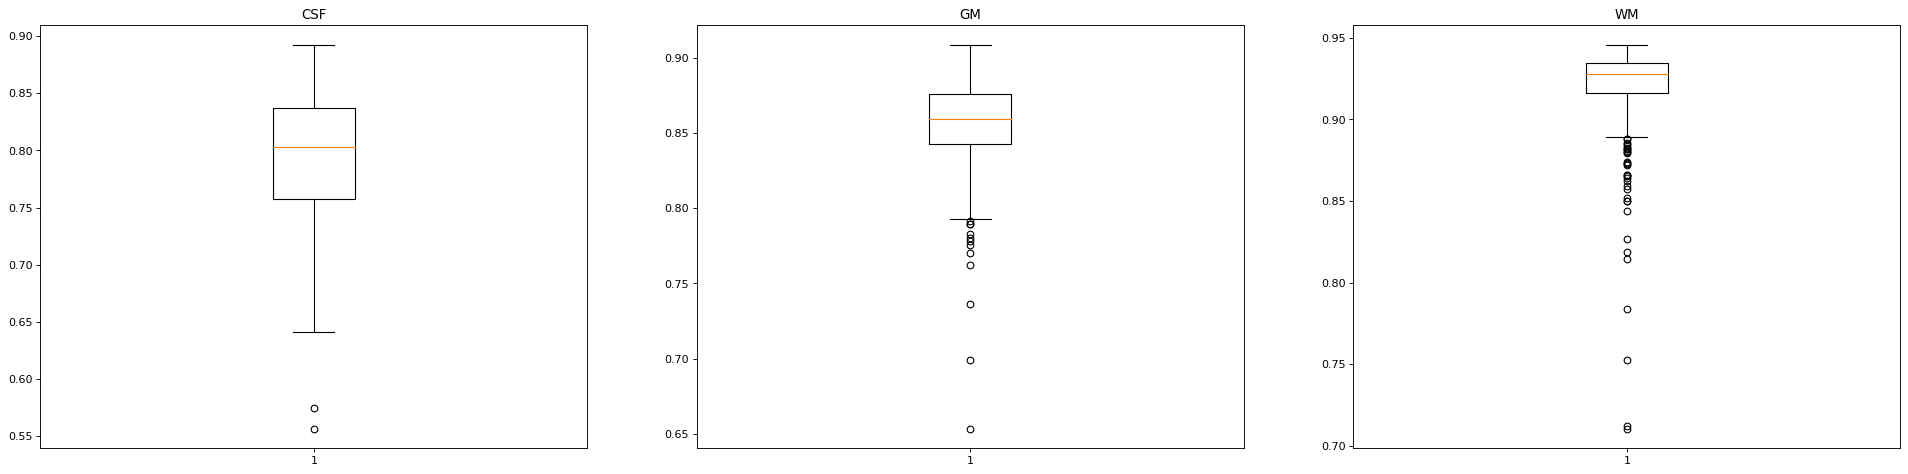

In [41]:
fig = plt.figure(num=None, figsize=(30, 7), dpi=80, facecolor='w', edgecolor='k')

# Returns the Axes instance
ax = fig.add_subplot(131) 
ax2 = fig.add_subplot(132) 
ax3 = fig.add_subplot(133) 
ax.title.set_text('CSF')
ax2.title.set_text('GM')
ax3.title.set_text('WM')

ax.boxplot(dice_CSF)
ax2.boxplot(dice_GM)
ax3.boxplot(dice_WM)
plt.savefig('dice.pdf')
plt.show()

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [42]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
# seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        
        seg_array = sitk.GetArrayFromImage(seg).flatten()

        vols[0, idx] = seg_array[seg_array == 1].shape[0]
        vols[1, idx] = seg_array[seg_array == 2].shape[0]
        vols[2, idx] = seg_array[seg_array == 3].shape[0]
        
        ########################################
        
print(vols)

Calculating Features: 100%|██████████| 500/500 [00:01<00:00, 370.03it/s]

[[24560. 20498. 25524. ... 22579. 22756. 27271.]
 [19803. 19796. 16312. ... 22925. 24835. 23471.]
 [14555. 11790. 11606. ... 13999. 15128. 15679.]]


Plot features versus age.

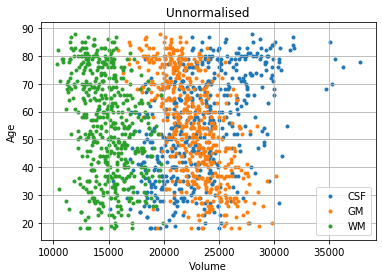

In [43]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.savefig('partAUnnorm.pdf')
plt.show()

In [44]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

########################################
# ADD YOUR CODE HERE
vols_normalised = vols / vols.sum(axis=0)
########################################

Plot normalised features versus age.

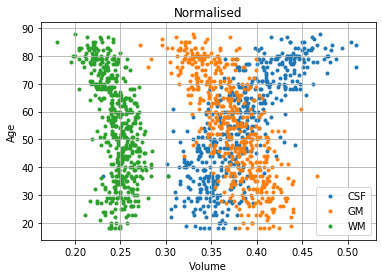

In [45]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.savefig('partAnorm.pdf')
plt.show()

Final data for age regression

In [46]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [47]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVR
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings('ignore')

In [48]:
########################################
# ADD YOUR CODE HERE

predicted_linearRegression = []
predicted_BayesianRegression = []
predicted_DecisionTreeReg = []
test_list = []

predicted_lr = np.zeros(y.shape)
predicted_br = np.zeros(y.shape)
predicted_dr = np.zeros(y.shape)

def cross_validation(input):
    kf = KFold(n_splits=2, shuffle=True)
    return kf.split(input)

for idx_train, idx_test in cross_validation(X):                                                                         #y_train:(375,1) y_test:(125,1)
    X_train, X_test = X[idx_train], X[idx_test]
    y_train, y_test = y[idx_train], y[idx_test]
    test_list.append(y_test)
    
    #Linear Regression, first regression method
    li_reg = linear_model.LinearRegression(normalize=True)
    li_reg.fit(X_train,y_train)
    li_reg_pred = li_reg.predict(X_test)
    predicted_lr[idx_test] = li_reg_pred
    predicted_linearRegression.append(li_reg_pred)

    
    #Bayesian Ridge Regression, second regression method
    br_reg = linear_model.BayesianRidge(normalize=True)
    br_reg.fit(X_train,y_train)
    br_reg_pred = br_reg.predict(X_test)
    br_reg_pred = br_reg_pred.reshape(br_reg_pred.shape[0],1)
    
    predicted_br[idx_test] = br_reg_pred
    predicted_BayesianRegression.append(br_reg_pred)
    
    
    #Decision Tree Regression, third regression method
    tr_reg = tree.DecisionTreeRegressor()
    tr_reg.fit(X_train,y_train)
    tr_reg_pred = tr_reg.predict(X_test)
    tr_reg_pred = tr_reg_pred.reshape(tr_reg_pred.shape[0],1)
    
    predicted_dr[idx_test] = tr_reg_pred
    predicted_DecisionTreeReg.append(tr_reg_pred)

########################################

In [105]:
#For test set uses
predicted_lr_test = li_reg.predict(X)
predicted_br_test = br_reg.predict(X)
predicted_dr_test = tr_reg.predict(X)

print('LR mean absolute error: {0}'.format(mean_absolute_error(y,predicted_lr_test)))
print('LR r2 score: {0}'.format(r2_score(y,predicted_lr_test)))
print('---------------------------------------------------------------------------')
print('BR mean absolute error: {0}'.format(mean_absolute_error(y,predicted_br_test)))
print('BR r2 score: {0}'.format(r2_score(y,predicted_br_test)))
print('---------------------------------------------------------------------------')
print('TR mean absolute error: {0}'.format(mean_absolute_error(y,predicted_dr_test)))
print('TR r2 score: {0}'.format(r2_score(y,predicted_dr_test)))
print('---------------------------------------------------------------------------')


#Linear Regression Plot
predicted_linearRegression = np.array(predicted_linearRegression)
max_lr = np.max(predicted_linearRegression) * 1.2

predicted_BayesianRegression = np.array(predicted_BayesianRegression)
max_br = np.max(predicted_BayesianRegression) * 1.2

predicted_DecisionTreeReg = np.array(predicted_DecisionTreeReg)
max_tr = np.max(predicted_DecisionTreeReg) * 1.2


fig = plt.figure(num=None, figsize=(30, 7), dpi=80, facecolor='w', edgecolor='k')

# Returns the Axes instance
ax = fig.add_subplot(131) 
ax2 = fig.add_subplot(132) 
ax3 = fig.add_subplot(133) 


ax.title.set_text('Linear Regression')
ax2.title.set_text('Bayesian Ridge Regression')
ax3.title.set_text('Decision Tree Regerssion')

ax.scatter(y, predicted_lr_test, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
# ax.legend()

ax2.scatter(y, predicted_br_test, marker='.')
ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'b', lw=2)
ax2.set_xlabel('Real Age')
ax2.set_ylabel('Predicted Age')
# ax2.legend()

ax3.scatter(y, predicted_dr_test, marker='.')
ax3.plot([y.min(), y.max()], [y.min(), y.max()], 'r', lw=2)
ax3.set_xlabel('Real Age')
ax3.set_ylabel('Predicted Age')
# ax3.legend()

plt.savefig('resultA_test.pdf')
plt.show()

Error calculation and plotting

LR mean absolute error: 9.66453125
LR r2 score: 0.5735792579459413
---------------------------------------------------------------------------
BR mean absolute error: 9.666250293228419
BR r2 score: 0.573624109862617
---------------------------------------------------------------------------
TR mean absolute error: 12.174
TR r2 score: 0.27349046421787027
---------------------------------------------------------------------------


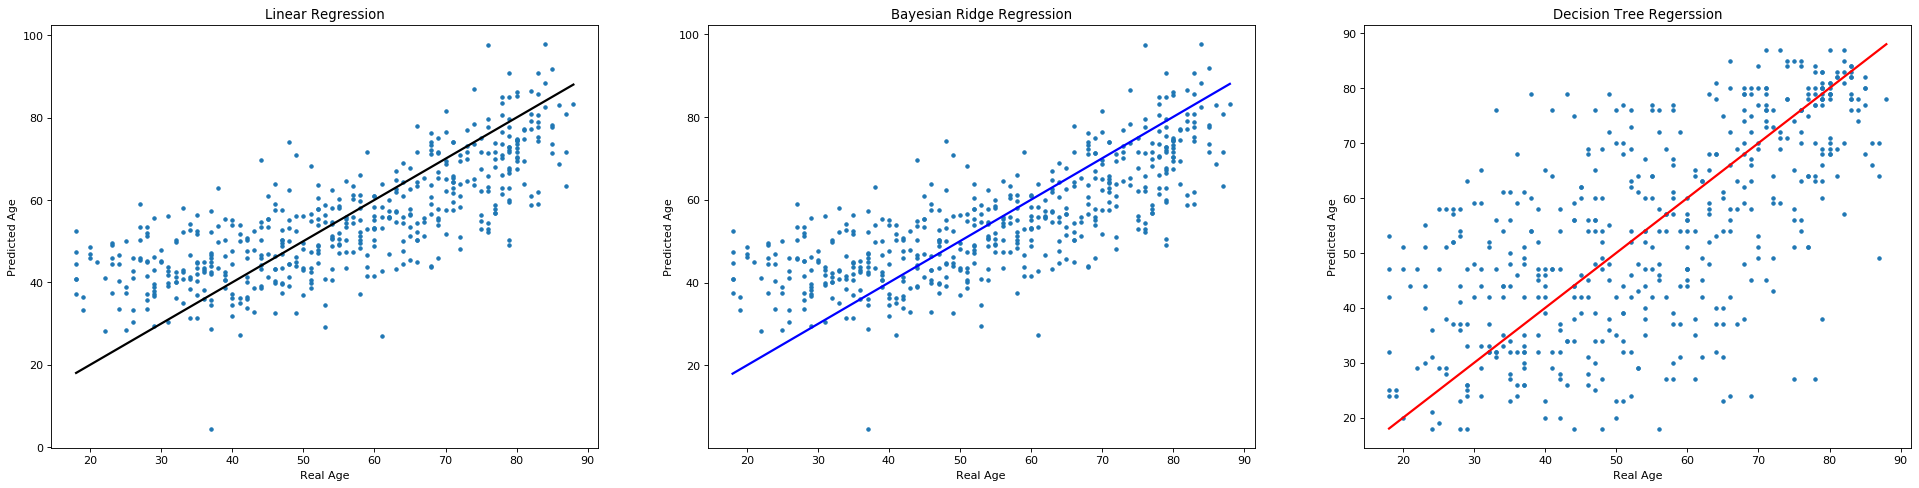

In [49]:
print('LR mean absolute error: {0}'.format(mean_absolute_error(y,predicted_lr)))
print('LR r2 score: {0}'.format(r2_score(y,predicted_lr)))
print('---------------------------------------------------------------------------')
print('BR mean absolute error: {0}'.format(mean_absolute_error(y,predicted_br)))
print('BR r2 score: {0}'.format(r2_score(y,predicted_br)))
print('---------------------------------------------------------------------------')
print('TR mean absolute error: {0}'.format(mean_absolute_error(y,predicted_dr)))
print('TR r2 score: {0}'.format(r2_score(y,predicted_dr)))
print('---------------------------------------------------------------------------')


#Linear Regression Plot
predicted_linearRegression = np.array(predicted_linearRegression)
max_lr = np.max(predicted_linearRegression) * 1.2

predicted_BayesianRegression = np.array(predicted_BayesianRegression)
max_br = np.max(predicted_BayesianRegression) * 1.2

predicted_DecisionTreeReg = np.array(predicted_DecisionTreeReg)
max_tr = np.max(predicted_DecisionTreeReg) * 1.2


fig = plt.figure(num=None, figsize=(30, 7), dpi=80, facecolor='w', edgecolor='k')

# Returns the Axes instance
ax = fig.add_subplot(131) 
ax2 = fig.add_subplot(132) 
ax3 = fig.add_subplot(133) 


ax.title.set_text('Linear Regression')
ax2.title.set_text('Bayesian Ridge Regression')
ax3.title.set_text('Decision Tree Regerssion')

ax.scatter(y, predicted_lr, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
# ax.legend()

ax2.scatter(y, predicted_br, marker='.')
ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'b', lw=2)
ax2.set_xlabel('Real Age')
ax2.set_ylabel('Predicted Age')
# ax2.legend()

ax3.scatter(y, predicted_dr, marker='.')
ax3.plot([y.min(), y.max()], [y.min(), y.max()], 'r', lw=2)
ax3.set_xlabel('Real Age')
ax3.set_ylabel('Predicted Age')
# ax3.legend()

plt.savefig('resultA.pdf')
plt.show()

## Part B: PCA-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction may need to be performed before training a suitable regressor on the low-dimensional feature representation. We will use Principal Component Analysis (PCA) to do the dimensionality reduction. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms average age prediction accuracy.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues. You may want to consider other ways of pre-processing and you can find insipiration in the notebook on medical image computing `02-Intro-Medical-Image-Computing.ipynb`.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation each time you run the notebook.

In [50]:
########################################
# ADD YOUR CODE HERE
# from sklearn.preprocessing import normalize

out_dir_preprocess = './output/preprocessedMaps'
pred_dir_preprocess = os.path.join(out_dir_preprocess, 'pred')
if not os.path.exists(pred_dir_preprocess):
    os.makedirs(pred_dir_preprocess)

def read_image(ID):
    gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
    image = sitk.Cast(sitk.ReadImage(gm_filename),sitk.sitkFloat32)
    return image

def scaling(image):
    scale = 2.
    iscale = 1/scale;
    sz1,sp1,origin = image.GetSize(),image.GetSpacing(), image.GetOrigin()
    direction = image.GetDirection()
    sz2,sp2 = [int(n/scale) for n in sz1],[n*scale for n in sp1]
    return sz1,sz2,sp1,sp2

def enhancement(image):
    #Local contrast enhancement 
#     enhanced_img = sitk.AdaptiveHistogramEqualizationImageFilter().Execute(image)

    #Image based normalization
    enhanced_img = sitk.NormalizeImageFilter().Execute(image)
    return enhanced_img

def smoothing(normalized_img,sp1,sp2):
    #Smoothing 
    for direction in range(3):
        factor = sp2[direction] / sp1[direction]
        sigma  = 0.2 * factor
        img_af_smoothing = sitk.RecursiveGaussian(normalized_img,sigma=sigma,direction=direction)
    return img_af_smoothing
    
img_data = []
counter = 1
for idx in list(meta_data_reg_train['subject_id']):
    image = read_image(idx)
    print('Processing image ' + idx + ' ' + str((len(meta_data_reg_train['subject_id']) - counter)) + ' maps left.')
    counter += 1
    image = sitk.DiscreteGaussian(image,0.8)
    old_size,new_size,old_space,new_space = scaling(image)
    
    enhanced_img = enhancement(image)
    preprocessed_img = smoothing(enhanced_img,old_space,new_space)
    
    filename = 'Preprocessed_ ' + idx + '.nii.gz'
    sitk.WriteImage(preprocessed_img, os.path.join(pred_dir_preprocess, filename))
    
    img_ = sitk.GetArrayFromImage(preprocessed_img)
    img_size = img_.shape
    img_data.append(img_.flatten().squeeze())
img_data = np.array(img_data)
print('Processing complete.')

########################################

Processing image CC520745 499 maps left.
Processing image CC520239 498 maps left.
Processing image CC620592 497 maps left.
Processing image CC310391 496 maps left.
Processing image CC621011 495 maps left.
Processing image CC620499 494 maps left.
Processing image CC320698 493 maps left.
Processing image CC521040 492 maps left.
Processing image CC620259 491 maps left.
Processing image CC420162 490 maps left.
Processing image CC420094 489 maps left.
Processing image CC320088 488 maps left.
Processing image CC510015 487 maps left.
Processing image CC510304 486 maps left.
Processing image CC310407 485 maps left.
Processing image CC620885 484 maps left.
Processing image CC420454 483 maps left.
Processing image CC420143 482 maps left.
Processing image CC220335 481 maps left.
Processing image CC610212 480 maps left.
Processing image CC720941 479 maps left.
Processing image CC420623 478 maps left.
Processing image CC620610 477 maps left.
Processing image CC620429 476 maps left.
Processing image

Before pre-processing


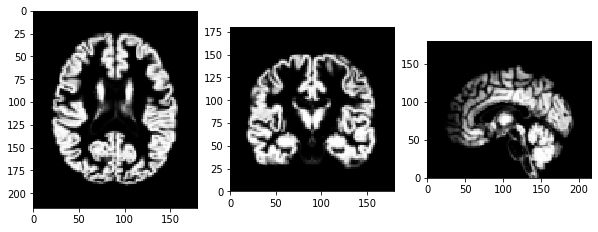

 
After pre-processing


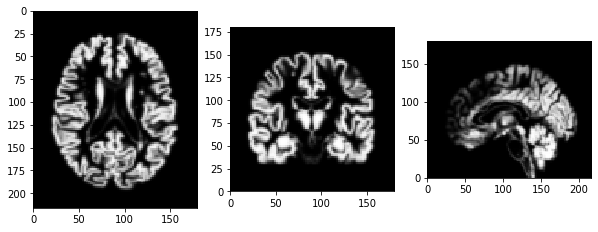

In [51]:
#Comparing grey matters before and after pre-processing
print('Before pre-processing')
display_image(gm)
print(' ')
print('After pre-processing')
display_image(preprocessed_img)

In [52]:
X = img_data
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(img_size)
print(X.shape)
print(y.shape)

(90, 108, 90)
(500, 874800)
(500, 1)


### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [53]:
########################################
# ADD YOUR CODE HERE
from sklearn.decomposition import PCA

def pca_computation(X_train,X_test):
    pca = PCA(n_components=0.95,whiten=False)

    X_train_prime = pca.fit_transform(X_train)
    X_test_prime  = pca.transform(X_test)
    
    return X_train_prime,X_test_prime

pca = PCA(n_components=0.95,whiten=False)

########################################

### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

In [54]:
########################################
# ADD YOUR CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

kfold = KFold(n_splits=2)

predicted_linearRegression_ = []
predicted_BayesianRegression_ = []
test_list_ = []
test_lr = np.zeros(y.shape)
test_br = np.zeros(y.shape)
test_lg = np.zeros(y.shape)
for idx_train_, idx_test_ in kfold.split(X):

    X_train_, X_test_ = X[idx_train_], X[idx_test_]
    y_train_, y_test_ = y[idx_train_], y[idx_test_]
    test_list_.append(y_test_)

    X_new_train_ = pca.fit_transform(X_train_)
    X_new_test_  = pca.transform(X_test_)
    
    print('Original shape: ', X_train_.shape)
    print('New shape: ', X_new_train_.shape)
    
    #Linear Regression, first regression method
    li_reg_ = linear_model.LinearRegression(normalize=True)
    li_reg_.fit(X_new_train_,y_train_)
    li_reg_pred_ = li_reg_.predict(X_new_test_)
    test_lr[idx_test_] = li_reg_pred_
    predicted_linearRegression_.append(li_reg_pred_)
    
    
    #Bayesian Ridge Regression, second regression method
    br_reg_ = linear_model.BayesianRidge(normalize=True)
    br_reg_.fit(X_new_train_,y_train_)
    br_reg_pred_ = br_reg_.predict(X_new_test_)
    br_reg_pred_ = br_reg_pred_.reshape(br_reg_pred_.shape[0],1)

    test_br[idx_test_] = br_reg_pred_
    predicted_BayesianRegression_.append(br_reg_pred_)
    
    #Logistic Regression, third regression method
    lg_reg_ = LogisticRegression().fit(X_new_train_,y_train_)
    lg_reg_pred_ = lg_reg_.predict(X_new_test_)
    lg_reg_pred_ = lg_reg_pred_.reshape(lg_reg_pred_.shape[0],1)
    
    test_lg[idx_test_] = lg_reg_pred_

########################################

Original shape:  (250, 874800)
New shape:  (250, 227)
Original shape:  (250, 874800)
New shape:  (250, 227)


In [46]:
#For test set uses

X = pca.transform(X)

test_lr_test = li_reg_.predict(X)
test_br_test = br_reg_.predict(X)
test_lg_test = lg_reg_.predict(X)

LR mean absolute error: 5.913546600341797
LR r2 score: 0.8630258840560068
-----------------------------------------------------------------------
BR mean absolute error: 6.198886457457829
BR r2 score: 0.8481400399828019
-----------------------------------------------------------------------
LR mean absolute error: 8.29
LR r2 score: 0.7022111896770071
-----------------------------------------------------------------------


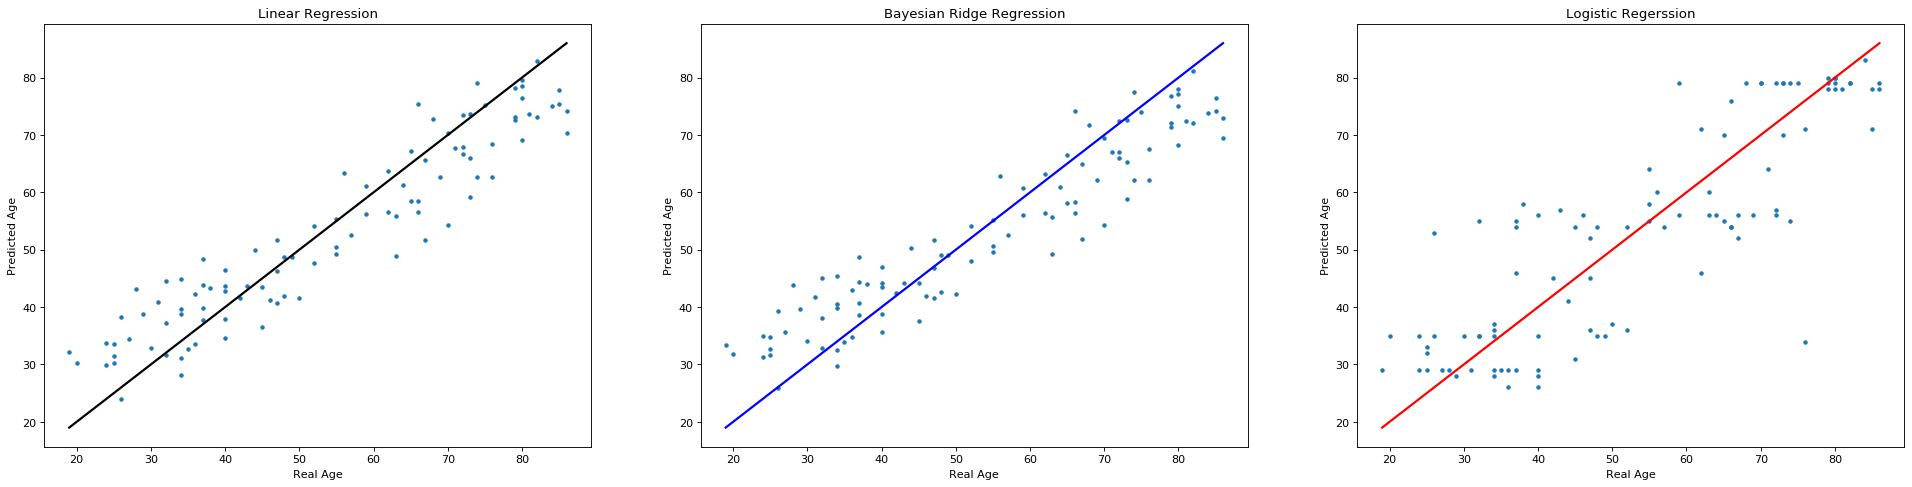

In [48]:
#For test set uses

print('LR mean absolute error: {0}'.format(mean_absolute_error(y,test_lr_test)))
print('LR r2 score: {0}'.format(r2_score(y,test_lr_test)))
print('-----------------------------------------------------------------------')
print('BR mean absolute error: {0}'.format(mean_absolute_error(y,test_br_test)))
print('BR r2 score: {0}'.format(r2_score(y,test_br_test)))
print('-----------------------------------------------------------------------')
print('LR mean absolute error: {0}'.format(mean_absolute_error(y,test_lg_test)))
print('LR r2 score: {0}'.format(r2_score(y,test_lg_test)))
print('-----------------------------------------------------------------------')

fig = plt.figure(num=None, figsize=(30, 7), dpi=80, facecolor='w', edgecolor='k')

# Returns the Axes instance
ax = fig.add_subplot(131) 
ax2 = fig.add_subplot(132) 
ax3 = fig.add_subplot(133) 


ax.title.set_text('Linear Regression')
ax2.title.set_text('Bayesian Ridge Regression')
ax3.title.set_text('Logistic Regerssion')

ax.scatter(y, test_lr_test, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
# ax.legend()

ax2.scatter(y, test_br_test, marker='.')
ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'b', lw=2)
ax2.set_xlabel('Real Age')
ax2.set_ylabel('Predicted Age')
# ax2.legend()

ax3.scatter(y, test_lg_test, marker='.')
ax3.plot([y.min(), y.max()], [y.min(), y.max()], 'r', lw=2)
ax3.set_xlabel('Real Age')
ax3.set_ylabel('Predicted Age')
# ax3.legend()

plt.savefig('resultB_test.pdf')
plt.show()

Error calculation and plotting

LR mean absolute error: 5.829030601501465
LR r2 score: 0.8495355869015176
-----------------------------------------------------------------------
BR mean absolute error: 6.047035022106583
BR r2 score: 0.8397244409000311
-----------------------------------------------------------------------
LR mean absolute error: 8.948
LR r2 score: 0.608314860887905
-----------------------------------------------------------------------


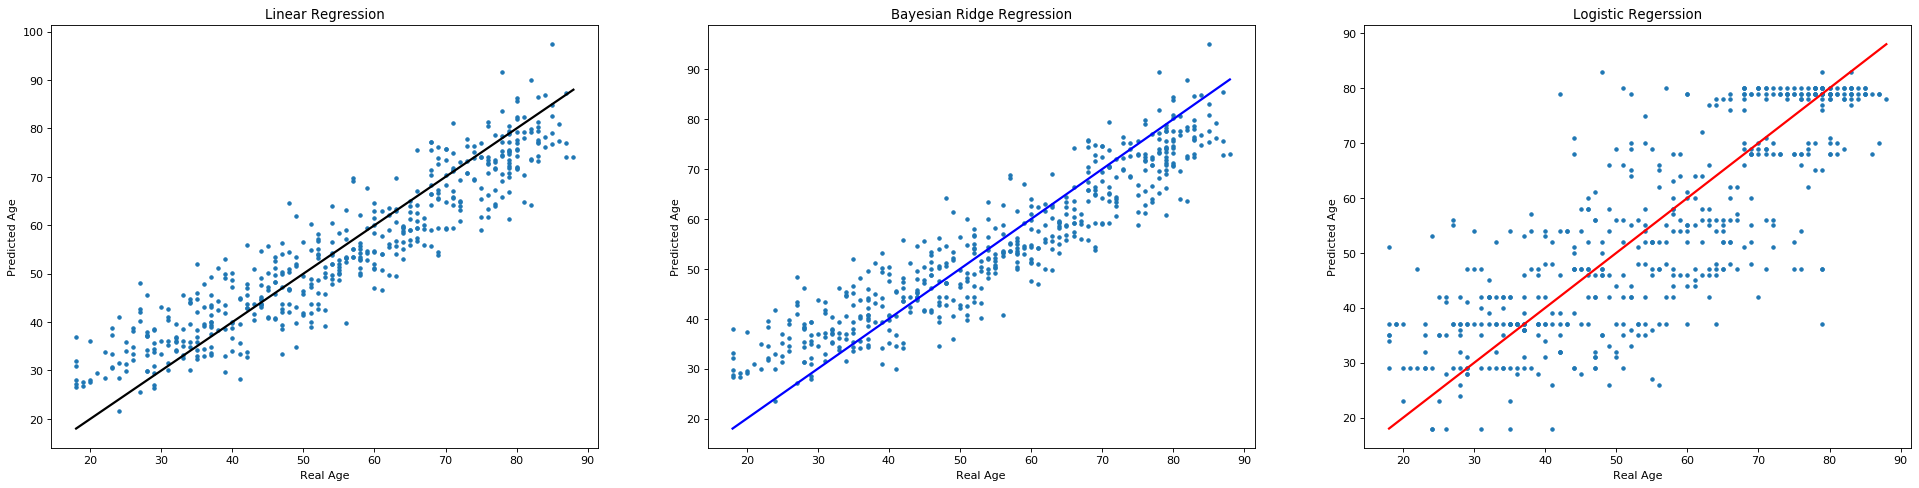

In [56]:
print('LR mean absolute error: {0}'.format(mean_absolute_error(y,test_lr)))
print('LR r2 score: {0}'.format(r2_score(y,test_lr)))
print('-----------------------------------------------------------------------')
print('BR mean absolute error: {0}'.format(mean_absolute_error(y,test_br)))
print('BR r2 score: {0}'.format(r2_score(y,test_br)))
print('-----------------------------------------------------------------------')
print('LR mean absolute error: {0}'.format(mean_absolute_error(y,test_lg)))
print('LR r2 score: {0}'.format(r2_score(y,test_lg)))
print('-----------------------------------------------------------------------')


fig = plt.figure(num=None, figsize=(30, 7), dpi=80, facecolor='w', edgecolor='k')

# Returns the Axes instance
ax = fig.add_subplot(131) 
ax2 = fig.add_subplot(132) 
ax3 = fig.add_subplot(133) 


ax.title.set_text('Linear Regression')
ax2.title.set_text('Bayesian Ridge Regression')
ax3.title.set_text('Logistic Regerssion')

ax.scatter(y, test_lr, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
# ax.legend()

ax2.scatter(y, test_br, marker='.')
ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'b', lw=2)
ax2.set_xlabel('Real Age')
ax2.set_ylabel('Predicted Age')
# ax2.legend()

ax3.scatter(y, test_lg, marker='.')
ax3.plot([y.min(), y.max()], [y.min(), y.max()], 'r', lw=2)
ax3.set_xlabel('Real Age')
ax3.set_ylabel('Predicted Age')
# ax3.legend()

plt.savefig('resultB.pdf')
plt.show()

## Part C: CNN-based regression using grey matter maps

The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, now we will use convolutional neural networks (CNNs) on the grey matter maps for predicting the subject's age directly.

You will need to implement a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from above tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to tasks A and B.

*Note:* For part C, only the spatially normalised grey matter maps should be used. Similar to task A, you may want to set up a configuration for the CNN training that may also involve some resampling of the input data.

In [97]:
num_epochs = 100
batch_size = 4

In [58]:
gm_img_train = [data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz' for ID in list(meta_data_reg_train['subject_id'])]

import torch
from torch.utils import data

class GMImageDataset(data.Dataset):
    
    def __init__(self, file_list_img, labels, new_size, new_spacing):
        self.samples = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            img = resample_image(img, new_spacing, new_size, is_label=False)
            
            sample = {'img': img, 'label': labels[idx]}
            
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        label = torch.from_numpy(sample['label'])
        label = label.type(torch.FloatTensor)

        return {'img': image, 'label': label}

new_size = [96, 96, 96]
new_spacing = [2, 2, 2]

In [61]:
#UNet Architecture
class UNet3D_C(nn.Module):
    def __init__(self, num_classes):
        super(UNet3D_C, self).__init__()

        activation = nn.LeakyReLU(0.2, inplace=True)

        # Downsample
        self.down1 = create_convolution_2_block(1, 32, activation)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.down2 = create_convolution_2_block(32, 64, activation)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

        # Bridge
        self.down3 = create_convolution_2_block(64, 128, activation) # [4, 128, 24, 24, 24]
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0) # [4, 128, 12, 12, 12]
        self.down4 = create_convolution_2_block(128, 64, activation) # [4, 64, 12, 12, 12]
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0) # [4, 64, 6, 6, 6]
        self.down5 = create_convolution_2_block(64, 32, activation) # [4, 32, 6, 6, 6]
        self.pool5 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0) # [4, 32, 3, 3, 3]
        self.fc1 = nn.Linear(864, 432)
        self.fc2 = nn.Linear(432, 216)
        self.fc3 = nn.Linear(216, 108)
        self.fc4 = nn.Linear(108, 1)

    def forward(self, x):

        down_1 = self.down1(x) # [4, 32, 64, 64, 64]
        pool_1 = self.pool1(down_1) # [4, 32, 32, 32, 32]
        down_2 = self.down2(pool_1) # [4, 64, 32, 32, 32]
        pool_2 = self.pool2(down_2) # [4, 64, 16, 16, 16]
        down_3 = self.down3(pool_2)
        pool_3 = self.pool3(down_3)
        down_4 = self.down4(pool_3)
        pool_4 = self.pool4(down_4)
        down_5 = self.down5(pool_4)
        pool_5 = self.pool5(down_5)
        out = pool_5.view(pool_5.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out

In [63]:
#LeNet Architecture

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 12, kernel_size=7, padding=0)
        self.batch1 = nn.BatchNorm3d(12)
        self.pool1 = nn.MaxPool3d(2,2)

        self.conv2 = nn.Conv3d(12, 8, kernel_size=6, padding=1)
        self.batch2 = nn.BatchNorm3d(8)
        self.pool2 = nn.MaxPool3d(2,2)

        self.conv3 = nn.Conv3d(8, 4, kernel_size=6, padding=0)
        self.pool3 = nn.MaxPool3d(2,2)

        self.fc1 = nn.Linear(2048, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool1(self.batch1(F.relu(self.conv1(x))))
        x = self.pool2(self.batch2(F.relu(self.conv2(x))))
        x = self.pool3(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
#Modified UNet 3D

class ModifiedUNet3D(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedUNet3D, self).__init__()

        activation = nn.LeakyReLU(0.2, inplace=True)

        # Downsample
        self.down1 = create_convolution_2_block(1, 32, activation)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.down2 = create_convolution_2_block(32, 64, activation)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

        # Bridge
        self.bridge = create_convolution_2_block(64, 128, activation)

        # Upsample
        self.trans1 = create_trans_block(128, 128, activation)
        self.upsample1 = create_convolution_2_block(192, 64, activation)

        self.trans2 = create_trans_block(64, 64, activation)
        self.upsample2 = create_convolution_2_block(96, 32, activation)

        self.out = create_convolution_block(32, num_classes, activation)
        self.out2 = nn.Conv3d(num_classes,1,kernel_size=1,padding=1)

        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.pool5 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(27,1)

    def forward(self, x):

        down_1 = self.down1(x) # [4, 32, 64, 64, 64]
        pool_1 = self.pool1(down_1) # [4, 32, 32, 32, 32]
        down_2 = self.down2(pool_1) # [4, 64, 32, 32, 32]
        pool_2 = self.pool2(down_2) # [4, 64, 16, 16, 16]

        bridge = self.bridge(pool_2) # [4, 128, 16, 16, 16]

        trans_1 = self.trans1(bridge) # [4, 128, 32, 32, 32]
        concat_1 = torch.cat([trans_1, down_2], dim=1) # [4, 192, 32, 32, 32]
        up_1 = self.upsample1(concat_1) # [4, 64, 32, 32, 32]

        trans_2 = self.trans2(up_1) # [4, 64, 64, 64, 64]
        concat_2 = torch.cat([trans_2, down_1], dim=1) # [4, 96, 64, 64, 64]
        up_2 = self.upsample2(concat_2) #

        out = self.out(up_2)
        out = self.out2(out)
        out = self.pool1(out)
        out = self.pool2(out)
        out = self.pool3(out)
        out = self.pool4(out)
        out = self.pool5(out)
        out = out.view(1,1,1,1,27)
        out = self.fc1(out)
        return out


Loading Data:   0%|          | 1/250 [00:00<00:44,  5.61it/s]

Parallel GPU in using



Loading Data: 100%|██████████| 250/250 [00:27<00:00,  8.98it/s]

Loading Data: 100%|██████████| 250/250 [00:27<00:00,  8.99it/s]


START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 19.628111
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 15.085179
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 14.755937
+ TRAINING 	Epoch: 3 	Loss: 10.662337
+ TRAINING 	Epoch: 4 	Loss: 9.737613
+ TRAINING 	Epoch: 5 	Loss: 11.922084
+ TRAINING 	Epoch: 6 	Loss: 8.420775
+ TRAINING 	Epoch: 7 	Loss: 8.844011
+ TRAINING 	Epoch: 8 	Loss: 7.834276
+ TRAINING 	Epoch: 9 	Loss: 7.884600
+ TRAINING 	Epoch: 10 	Loss: 7.719864
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 7.061584
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 7.548630
+ TRAINING 	Epoch: 12 	Loss: 6.917497
+ TRAINING 	Epoch: 13 	Loss: 6.643119
+ TRAINING 	Epoch: 14 	Loss: 7.748736
+ TRAINING 	Epoch: 15 	Loss: 6.293607
+ TRAINING 	Epoch: 16 	Loss: 5.895975
+ TRAINING 	Epoch: 17 	Loss: 5.147582
+ TRAINING 	Epoch: 18 	Loss: 4.788594
+ TRAINING 	Epoch: 19 	

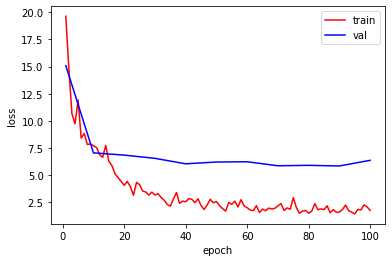


Loading Data:   0%|          | 0/250 [00:00<?, ?it/s]

Parallel GPU in using



Loading Data: 100%|██████████| 250/250 [00:26<00:00,  9.34it/s]

Loading Data: 100%|██████████| 250/250 [00:26<00:00,  9.60it/s]


START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 19.633234
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 14.811585
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 16.813123
+ TRAINING 	Epoch: 3 	Loss: 14.843495
+ TRAINING 	Epoch: 4 	Loss: 12.413709
+ TRAINING 	Epoch: 5 	Loss: 8.283819
+ TRAINING 	Epoch: 6 	Loss: 9.568598
+ TRAINING 	Epoch: 7 	Loss: 7.926085
+ TRAINING 	Epoch: 8 	Loss: 7.852230
+ TRAINING 	Epoch: 9 	Loss: 6.953801
+ TRAINING 	Epoch: 10 	Loss: 7.603181
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 9.157556
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 8.159684
+ TRAINING 	Epoch: 12 	Loss: 10.173315
+ TRAINING 	Epoch: 13 	Loss: 7.246442
+ TRAINING 	Epoch: 14 	Loss: 6.176838
+ TRAINING 	Epoch: 15 	Loss: 7.786686
+ TRAINING 	Epoch: 16 	Loss: 6.440755
+ TRAINING 	Epoch: 17 	Loss: 7.400167
+ TRAINING 	Epoch: 18 	Loss: 5.774469
+ TRAINING 	Epoch: 19 

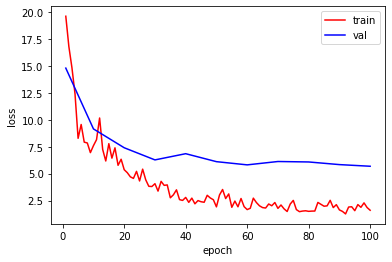

In [102]:
from sklearn.model_selection import KFold

model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

kf = KFold(n_splits=2,shuffle=True)
torch.manual_seed(rnd_seed) #fix random seed
# model = UNet3D(1).to(device)
# model = LeNet().to(device)
# # model = ModifiedUNet3D(1).to(device)
# model.to(device)
# if torch.cuda.device_count() > 1:
#     print('Parallel GPU in using')
#     model = nn.DataParallel(model)

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# model.train()
gm_img_train_np = np.array(gm_img_train)

counter = 0
best_val_err = 100
for train_index, test_index in kf.split(gm_img_train_np):
    model = LeNet().to(device)
    # model = vgg_16(1).to(device)
    model.to(device)
    if torch.cuda.device_count() > 1:
        print('Parallel GPU in using')
        model = nn.DataParallel(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    X_train, X_test = gm_img_train_np[train_index], gm_img_train_np[test_index]
    y_train, y_test = y[train_index], y[test_index]

    gm_image_dataset_train = GMImageDataset(X_train, y_train, new_size, new_spacing)
    gm_image_dataset_test = GMImageDataset(X_test, y_test, new_size, new_spacing)

    dataloader_gm_train = torch.utils.data.DataLoader(gm_image_dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_gm_test = torch.utils.data.DataLoader(gm_image_dataset_test, batch_size=batch_size, shuffle=True)

    loss_train_log_ = []
    loss_val_log_ = []
    epoch_val_log_ = []
    print('START TRAINING...')

    for epoch in range(1, num_epochs + 1):
        # Training
        epoch_loss = 0
        for batch_idx, batch_samples in enumerate(dataloader_gm_train):
            img, y_gm = batch_samples['img'].to(device), batch_samples['label'].to(device)
            y_gm = y_gm.view(y_gm.size(0),-1)
            optimizer.zero_grad()
            prd = model(img)
            prd__ = prd.view(prd.size(0), -1)
            loss = F.l1_loss(prd__,y_gm)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        loss_train_log_.append(epoch_loss/len(dataloader_gm_train))

        print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, epoch_loss/len(dataloader_gm_train)))

        # Validation
        if epoch == 1 or epoch % val_interval == 0:
            loss_val = 0
            # For plotting
            y_values = []
            pred_values = []
            with torch.no_grad():
                for data_sample in dataloader_gm_test:
                    img, y_gm_val = data_sample['img'].to(device), data_sample['label'].to(device)
                    prd = model(img)
                    prd__ = prd.view(prd.size(0), -1)
                    y_gm_val = y_gm_val.reshape(y_gm_val.size(0),-1)
                    #                     loss_val += F.l1_loss(prd__,y_gm_val).item()
                    y_values.extend(y_gm_val.flatten().tolist())
                    pred_values.extend(prd__.flatten().tolist())

#             loss_val /= len(dataloader_test)
            loss_val = mean_absolute_error(y_values, pred_values)
            epoch_val_log_.append(epoch)
            loss_val_log_.append(loss_val)

            print('--------------------------------------------------')
            print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
            print('--------------------------------------------------')
            if loss_val < best_val_err:
                best_val_err = loss_val
                best_model = model
                torch.save(best_model.state_dict(), os.path.join(model_dir, 'model_best_model.pt'))
    # torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))
    print('\nFinished TRAINING.')

    plt.plot(range(1, num_epochs + 1), loss_train_log_, c='r', label='train')
    plt.plot(epoch_val_log_, loss_val_log_, c='b', label='val')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [103]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_reg = list(meta_data_reg_test['subject_id'])
files_reg_img_test = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_reg]
test_dataset = GMImageDataset(files_reg_img_test, meta_data_reg_test['age'].values.reshape(-1,1), new_size, new_spacing)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Loading Data: 100%|██████████| 100/100 [00:10<00:00,  9.46it/s]


In [105]:
#For test set uses 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
	os.makedirs(pred_dir)

model = LeNet()
if torch.cuda.device_count() > 1:
	print('Parallel GPU in using')
	model = nn.DataParallel(model)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model_best_model.pt')))
model.to(device)
model.eval()

# model.eval()
y_values = []
pred_values = []
with torch.no_grad():
	for data_sample in dataloader_test:
		img, y_val = data_sample['img'].to(device), data_sample['label'].to(device)
		prd = model(img)
		prd__ = prd.view(prd.size(0), -1)
		y_val = y_val.reshape(y_val.size(0),-1)
		y_values.extend(y_val.flatten().tolist())
		pred_values.extend(prd__.flatten().tolist())

final_mae = mean_absolute_error(y_values, pred_values)
print('--------------------------------------------------')
print('+ TESTING \tMAE: {}'.format(final_mae))
print('--------------------------------------------------')

final_r2 = r2_score(y_values,pred_values)
print('--------------------------------------------------')
print('+ TESTING \tr2: {}'.format(final_r2))
print('--------------------------------------------------')

Parallel GPU in using
--------------------------------------------------
+ TESTING 	MAE: 6.106610507965088
--------------------------------------------------
--------------------------------------------------
+ TESTING 	r2: 0.844344020713735
--------------------------------------------------


Error calculation and plotting

In [ ]:
plt.scatter(y_values, pred_values,marker='.')
# plt.plot(epoch_val_log_, loss_val_log_, c='b', label='val')
plt.plot([min(y), max(y)], [min(y), max(y)],c='k')
plt.xlabel('Real Age')
plt.ylabel('Predicted Age')
plt.savefig('resultC.pdf')
plt.show()